
- Column1: Device ID
- Column2: accelerometer x
- Column3: accelerometer y
- Column4: accelerometer z
- Column5: gyroscope x
- Column6: gyroscope y
- Column7: gyroscope z
- Column8: magnetometer x
- Column9: magnetometer y
- Column10: magnetometer z
- Column11: Timestamp
- Column12: Activity Label (16 atividades)


In [27]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import utils


In [30]:

loc = []

for i in range (0,15):
    loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

df = pd.read_csv(loc[0], sep=',', header=None)
array = df.to_numpy()

t_acc = np.sqrt(np.add(np.square(array[:,1]),
                       np.square(array[:,2]),
                       np.square(array[:,3])))

t_gyr = np.sqrt(np.add(np.square(array[:,4]),
                       np.square(array[:,5]),
                       np.square(array[:,6])))

t_mag = np.sqrt(np.add(np.square(array[:,7]),
                       np.square(array[:,8]),
                       np.square(array[:,9])))


,0,1,2,3,4,5,6,7,8,9,10,11
0,2,3.0317,9.0450,3.1739,0.76247,3.7071,-0.31384,0.57764,0.68849,1.2654,63.629,1
1,2,2.9591,9.0436,3.1400,0.40588,4.6682,-0.10148,0.58385,0.68849,1.2741,83.160,1
2,2,2.9465,9.0545,3.0799,0.24230,5.5225,0.34857,0.56522,0.67857,1.2675,102.690,1
3,2,2.7898,9.0528,3.0726,0.49858,6.3463,0.61127,0.56108,0.65476,1.2610,122.220,1
4,2,2.6924,9.0377,2.9794,0.63197,6.6972,1.00560,0.57764,0.69246,1.2675,141.750,1


<Figure size 640x480 with 0 Axes>

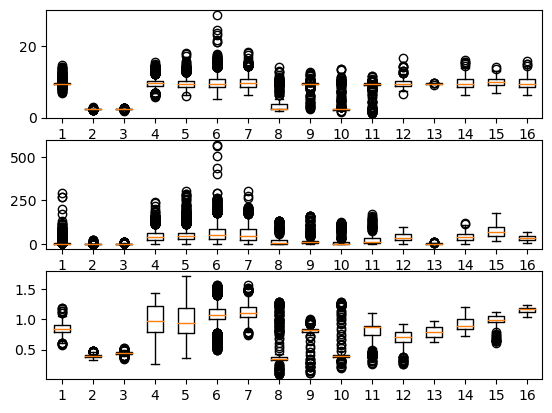

In [18]:


# act1 = t_acc[array[:,-1]==5]

activities = np.arange(1, 17) # nao sei se util
box_acc = [] # TODO ver se dá para fazer isto com np.array
box_gyr = []
box_mag = []
for i in range(1,17):
    act = (array[:,-1]==i)
    #length = np.sum(act)
    box_acc.append(t_acc[act]) # TODO outra forma?
    box_gyr.append(t_gyr[act])
    box_mag.append(t_mag[act])

#box_acc = np.array(box_acc)
plt.figure()
fig, axs = plt.subplots(3)
axs[0].boxplot(box_acc)
axs[1].boxplot(box_gyr)
axs[2].boxplot(box_mag)
plt.show()

In [19]:

# desvio e outliers para cada k = 3, 3.5, 4
d = []
outliersk = [] 

x_density = 5 # percentage

# for c, d in zip(a, b) itera alternadamente cada lista no mesmo loop
for box in ([box_acc, box_gyr, box_mag]):
    for i in range(16):
        q1 = np.quantile(box[:][i], 0.25)
        q3 = np.quantile(box[:][i], 0.75)
        #av = np.average(box[:][i])
        
        iqr = q3-q1
        upper_bound = q3+(1.5*iqr)
        lower_bound = q1-(1.5*iqr)
    
        outliers = box[:][i][(box[:][i] <= lower_bound) | (box[:][i] >= upper_bound)]
        out_bool = (box[:][i] <= lower_bound) | (box[:][i] >= upper_bound)
        #print('The following are the outliers in the boxplot:{}'.format(outliers))
        box[:][i] = box[:][i][(box[:][i] >= lower_bound) & (box[:][i] <= upper_bound)]
        
        #unique, counts = np.unique(out_bool, return_counts=True)
        #desvios
        counts = np.count_nonzero(out_bool==True)
        d.append((counts/out_bool.size)*100) # TODO se a coluna nao tiver desvios
        
        zscore = stats.zscore(box[:][i], axis=0, ddof=0, nan_policy='propagate')
        outliersk.append(box[:][i][(zscore <= -3) | (zscore >= 3)])
        #print('The following are the outliers from the z-score test: {}'.format(outliersk[:][i]))
        
        #iterar para cada coluna
        centroids, cluster = utils.k_means(box[:][i], 3)


In [20]:
t_out, td = utils.get_outliers(t_acc)
p = t_out.shape[0]
acc_out = utils.inject_outliers(10, 4, t_out, p)
# os valores mudam mesmo apesar do teste as array dar igual

804


In [26]:
coef = []
for vec in box_acc:
    
    n = vec.size    
    ran = np.ptp(vec)
    test = np.random.rand(n)*ran
    #print(np.reshape(test[:n], (-1,1)))
    #print(np.reshape(vec[:n], (-1,1)).shape)
    test = np.append(test[:n], test[:n]).reshape(-1, 2)
    coef.append(utils.fit_linear(test, vec, n))



In [23]:

for i in range(16):
    stats.kstest(box_acc[:][i], 'norm') # if follows a gaussian
